# Creating an Image Dataset from scratch

With the steps below, you can create a dataset from any images on the internet. I'm doing a knife classifier, but with a few simple code changes you can create your own dataset of any classes you like.

You don't always have to create your own dataset to do machine learning– there are plenty of public datasets (check out [kaggle](https://www.kaggle.com/), for example) but for a custom task like classifying knives we'll need to create our own. All we need is Google Images and a few helpful Python scripts.

*This is written in a [Jupyter Notebook](http://jupyter.org/), in Python. Don't have Python? Download it [here](https://anaconda.org/anaconda/python).*

In [1]:
# libraries that manipulate and display image data.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import shutil

## Directory Structure

What does the computer need to judge knives? We need positive examples (knives), negative examples (not knives), and a way to tell the computer which are which. 

One popular method is a **'PATH' structure**, which separates classes by folder. For knives, that simply means putting knives in one folder and 'not knives' in a second folder. That's all the labelling our data needs.

You can have two classes or as many classes as you like– all you have to do is create a sub-folder for each class.

In [2]:
# PATH establishes our working directory, the place where our dataset lives.
PATH = "data/knife-or-not/"

# Function to create a folder, if it doesn't exist already.
def create_folder(location):
    if not os.path.isdir(f'{PATH}{location}'):
        os.makedirs(f'{PATH}{location}')

# NOTE: Modify the list below to reflect your classes. You can add more: 'train/{your class}'
training = ['train', 'train/knife', 'train/not_knife']

for folder in training:
    create_folder(folder)

os.listdir(f'{PATH}train')

['not_knife', 'knife']

From our main training dataset, we need to set aside a portion to periodically test our algorithm on unseen examples. This is called a **validation set** and without it, you really have no idea if your model is improving or not. So you really need one. Check out this [great article](http://www.fast.ai/2017/11/13/validation-sets/) to learn more about validation sets.

Structurally our validation set works just like our training dataset, with a folder for each class. So ultimately, our dataset contains two data folders('train' and 'valid') with two subfolders in each ('knife' and 'not-knife').

In [3]:
# This should be the same structure as your training folders above.
validation = ['valid', 'valid/knife', 'valid/not_knife']

for folder in validation:
    create_folder(folder)

os.listdir(f'{PATH}valid')

['not_knife', 'knife']

# Collecting Knife Data

Now that we have our structure, it's time fill it with data. For knife images, we turn to Google Images and a nifty python [scraping script](https://github.com/hardikvasa/google-images-download). 


First, a bit of installing: open your terminal, navigate to your dataset location and type in the following. (*If you don't have a github account yet, go grab one and come back.*)
```
$ git clone https://github.com/hardikvasa/google-images-download.git
$ cd google-images-download && sudo python setup.py install

```

### Easy, Small Dataset

Just want a quick dataset to play with? Those two install lines are enough to get started. You can grab up to 100 images for each keyword, but you can add as many keyword arguments as you want. The more keywords, the bigger your dataset and the better your algorithm. Check out the author's [documentation](https://github.com/hardikvasa/google-images-download#examples) for call examples. 

This call below would grab 400 images.

In [4]:
knife_keywords = ['knife', 'knives', 'hunting knife', 'sharp knife']

In [ ]:
import subprocess
for keyword in knife_keywords:
    subprocess.call(["googleimagesdownload", "-fjpg","-k"+keyword, '-l100', "-odata/knife-or-not/knife"])

### Bigger Dataset

Want to create a bigger dataset? 

In your terminal, download [**Selenium**](https://www.seleniumhq.org/):
```
sudo easy_install selenium
```

Then download Chromedriver [here](https://sites.google.com/a/chromium.org/chromedriver/downloads) and put it in the same location as your PATH directory. (Google Chrome must be installed and up to date as well.) 

For this to work properly, Chromedriver must be *running*. In your terminal, open a new separate window and navigate to your chromedriver location. Then type: `chromedriver` to activate it. You should see something like this: 

```Starting ChromeDriver 2.39.562713 (dd642283e958a93ebf6891600db055f1f1b4f3b2) on port 9515```

With Selenium and Chromedriver, one keyword search can potentially grab thousands of images. In practice, it grabs as many images as Google returns for the keyword, typically around 400-500. So we'll still use various adjectives to amplify our search and return more images.

In [5]:
# Modify the below list to reflect your classes
knife_keywords = ['knife','knives','hunting knife','fillet knife','cutting knife','chef knife','sharp knife', 'fishing knife', 'weapon knife', 'machete']

In [147]:
import subprocess
for keyword in knife_keywords:
    subprocess.call(["googleimagesdownload", "-fjpg","-k" + keyword, '-l1000', "-odata/knife-or-not/knife"])

# First look at knife pictures

295. gyuto_chef_knife_1.jpg


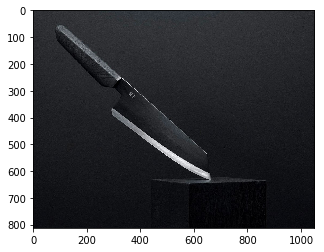

In [9]:
# Run cell to see a knife image at random
key = knife_keywords[np.random.randint(0, len(knife_keywords))]
file = os.listdir(f'{PATH}knife/{key}')
knife = np.random.randint(0, len(file))
print(file[knife])

img = plt.imread(f'{PATH}knife/{key}/{file[knife]}')
plt.imshow(img);

What does the raw data looks like? A three-dimensional array of RGB pixel levels.

In [10]:
img.shape

(812, 1050, 3)

In [11]:
img[:4,:4]

array([[[52, 53, 57],
        [47, 48, 52],
        [43, 44, 48],
        [45, 46, 50]],

       [[51, 52, 56],
        [51, 52, 56],
        [52, 53, 57],
        [51, 52, 56]],

       [[46, 47, 51],
        [51, 52, 56],
        [54, 55, 59],
        [52, 53, 57]],

       [[46, 47, 51],
        [50, 51, 55],
        [50, 51, 55],
        [46, 47, 51]]], dtype=uint8)

# Collecting 'Not Knife' Data

If we want our algorithm to recognize the positive example ('this is a knife'), it needs negative examples as well– things that *aren't* knives. 

But how do we get images that are NOT something? If you search Google Images for '-knife' (bool for NOT knife), there are no results. We cannot image search a negative. So we'll do the next best thing: gathering small batches of **randomized keywords**, thanks to another handy Python [script](https://pypi.org/project/RandomWords/).

Open your terminal, navigate to your PATH location and install like so: ```pip install RandomWords```

In [22]:
# See how many knife images we've collected
len(os.listdir(f'{PATH}knife'))

11

We're capturing only a few images per keyword, so no need for Selenium and Chromedriver here. Play with the 'count' argument to gather less or more images. This call will retrieve (count x 20) images.

In [158]:
from random_words import RandomWords

rw = RandomWords()
not_knife_keywords = rw.random_words(count=150)
assert('knife' not in not_knife_keywords)

for keyword in not_knife_keywords:
    subprocess.call(["googleimagesdownload", "-fjpg","-k" + keyword, '-l20', "-odata/knife-or-not/not_knife"])

# Clean up

Once we have all of images, time for a bit of tidying and file formatting. The scraping code above downloads each keyword's images into their own folder, so we'll merge all those images into the parent folder.

In [20]:
# Modify the next line to reflect your classes.
classes = ['knife','not_knife']

for item in classes: 
    destination = f'{PATH}{item}'
    
    # Move all files to main folder/remove individual keyword folders
    for keyword in os.listdir(destination): 
        if os.path.isdir(f'{destination}/{keyword}'):
            for file in os.listdir(f'{destination}/{keyword}'):
                shutil.copy(f'{destination}/{keyword}/{file}', destination) 
            shutil.rmtree(f'{destination}/{keyword}')
    
    # Remove numbers at beginning of filenames
    for file in os.listdir(destination):        
        if '. ' in file:
            newname = file.split('. ')[1]
            if newname != '':
                os.rename(f'{PATH}{item}/{file}', f'{PATH}{item}/{newname}')

Now we have all knife images together in one folder, and all not-knife images in a separate folder.

In [21]:
# cleaned up knife images
os.listdir(f'{PATH}knife')[:5]

['cke15000-rocker-knife-white-w.jpg',
 'br-kbrtc.jpg',
 'custom-knives-clip-point-hunt-2.jpg',
 'olfa_125mm_wallpaper_cutting_knife.jpg',
 'laramie-jackson-custom-knives-loveless-turqoise-ironwood1.jpg']

In [22]:
# cleaned up not_knife images
os.listdir(f'{PATH}not_knife')[:5]

['gray-nicolls%20sheffield%20stumps.jpg',
 'landscape-1491473934-acnevaccine.jpeg',
 'door-latch-vol-01-3d-model-max-obj-fbx-mtl-mat.jpg',
 '51580b05c2419134a6ae0f3d715efba12a472a22.jpg',
 'disabilities.jpg']

# Create train/validation sets

Now that we have all of our images, we'll split them into the train and validation folders we created earlier. A typical approach is a 80/20 split, with 80% of our data devoted to training the algorithm and 20% held back to check our improvement (or lack thereof).

In [6]:
classes = ['knife','not_knife']
classes

['knife', 'not_knife']

In [7]:
for item in classes:
    m = len(os.listdir(f'{PATH}{item}'))
    print(f'total number of {item} images: ' + str(m))
    
    # random indices totalling 20%
    valid_idx = np.random.randint(0, high=(m-(m/5)), size=int(m/5)) 
    
    # move randomly indexed files to validation folder
    for idx in valid_idx:
        file = os.listdir(f'{PATH}{item}')[idx]
        src = f'{PATH}{item}/'
        dst = f'{PATH}valid/{item}/'
        shutil.move(os.path.join(src, file), os.path.join(dst, file))
        
    # move remaining images into training folder
    for file in os.listdir(f'{PATH}{item}'):
        shutil.move(f'{PATH}{item}/{file}', f'{PATH}train/{item}')
    
    # delete empty class folder
    shutil.rmtree(f'{PATH}{item}')

total number of knife images: 4416
total number of not_knife images: 2819


In [8]:
os.listdir(f'{PATH}train')

['not_knife', 'knife']

In [9]:
# knife training images
len(os.listdir(f'{PATH}train/knife'))

3533

In [10]:
# knife validation images
len(os.listdir(f'{PATH}valid/knife'))

883

In [11]:
# not_knife training images
len(os.listdir(f'{PATH}train/not_knife'))

2256

In [12]:
# not_knife validation images
len(os.listdir(f'{PATH}valid/not_knife'))

563

# Conclusion

That's it! We now have a training set and validation set, each with a folder of images for each class we want to predict. This same approach applies to multiple image classes as well (say, apples vs. oranges. vs pears).

This is the first part of any machine learning project: collecting, exploring and formatting our input data in a way that machines can use. In the next notebook, we'll use this data to create an algorithm that can answer to any image: 'knife' or 'not knife'.